# **Term Project:**
### **Subject:** CSE-5334-003: Data Mining
### **Name:** Nisarg Pawar
### **ID:** 1001720812

**Goal:** Build a Classifier by processing Board Game Reviews dataset and predicts rating of the review. 
 - Try out different techniques of word embedding and vectorizations. 
     - Vectorization techniques:
        - bag of words (word count vector)
        - tf-idf vector
 - Try out different types of vector classification techniques and pick the best solution based on its accuracy over test data.
     - classification techniques:
        - Linear regression
        - Naive Bayes

---
#### **Process:**
- Step 1: Pre-process and clean data and create vocabulary:
    - Remove special characters and extra spaces
    - Removing single characters - I and a. And others created due to removal of special characters
    - Lowercase all text
- Step 2: Train, Dev and Test split.
- Step 3: Vectorize the document, Remove the stop words
    - bag of words (word count vector)
    - tf-idf vector
- Step 4: Classifier Evaluation:
    - Linear regression
    - Naive Bayes
- Step 5: Evaluation and Hyper-Parameter tuning on Test results:
    - max_features= between 100 to 2000 with a jump of 100.
- Step 6: Saving and Loading model mechanizm.
- Step 7: Store best model.

In [1]:
# imports
import re
import os
import nltk
import math
import sklearn
import pickle
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

from nltk.tokenize import RegexpTokenizer

---
### Exploratory Analysis:
- reviewing each file available in the dataset and identifying the relevant one.

In [2]:
f2 = pd.read_csv('archive/bgg-15m-reviews.csv', index_col = 0)
f2.head()

/home/nisarg/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,user,rating,comment,ID,name
0,Torsten,10.0,NaN,30549,Pandemic
1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,Mike Mayer,10.0,NaN,30549,Pandemic
4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic


There are several NaN comments visible, these have no use and should be dropped.

We also need only two columns = ['comment','rating'] -> [X,y]

---
### Step 1: Pre-process and clean data:
 - remove Nan entries.
 - Remove special characters and extra spaces
 - Removing single characters - I and a. And others created due to removal of special characters
 - Lowercase all text

In [3]:
dataset = f2[['comment','rating']]
dataset.shape

(15823269, 2)

In [4]:
dataset = dataset.dropna()
dataset.shape

(2995023, 2)

Substantial dataset size reduction observed.

In [5]:
dataset['comment'] = dataset['comment'].str.lower() # lowercase text
dataset['comment'] = dataset['comment'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x)) # remove special characters
dataset['comment'] = dataset['comment'].apply(lambda x: re.sub(r'\s+\w\s+', ' ', x)) # remove single characters
dataset['comment'] = dataset['comment'].apply(lambda x: re.sub(r'\s{2,}', ' ', x)) # remove extra spaces

#### Some more analysis over data now that its clean:

In [6]:
# class distribution
len(dataset['rating'].unique())

4384

Rating values look too distributed. It seems we must pre process the ratings as well. Converting each to int. Since they must be between 0 to 10 we shall get the ceiling value and replace the rating. eg: if rating is 5.5 -> 6

In [7]:
dataset['rating'] = dataset['rating'].apply(lambda x: int(math.ceil(x)))
len(dataset['rating'].unique())

10

In [8]:
result = dataset.groupby('rating').count()
result

,comment
rating,
1,23180
2,42388
3,80821
4,139998
5,250352
6,484227
7,728052
8,689314
9,362248


<AxesSubplot:xlabel='rating'>

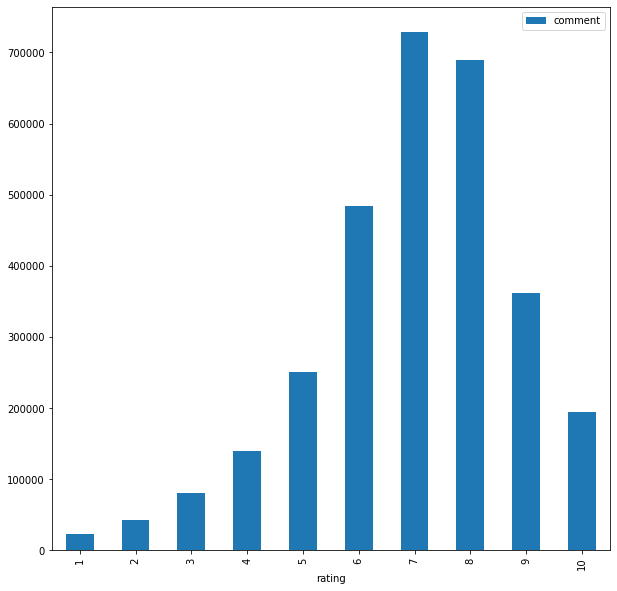

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

result.plot(kind='bar')

#### Now, We analyse the length of reviews in terms of words.

In [10]:
tokenizer = RegexpTokenizer(r'\w+')

dataset["words"] = dataset["comment"].apply(tokenizer.tokenize)

word_list = [word for words in dataset["words"] for word in words]
rev_len = [len(words) for words in dataset["words"]]
vocabulary = sorted(list(set(word_list))) # unique list of words A-Z
print("total words:",len(word_list))
print("total unique words:",len(vocabulary))
print("Max sentence length is: ", max(rev_len))
print("Average length: ", np.mean(rev_len))

total words: 109051870
total unique words: 686137
Max sentence length is:  4346
Average length:  36.411029230827275


In [11]:
dataset.to_csv('dataset.csv',index=False)

In [2]:
dataset = pd.read_csv('dataset.csv') 

 - Each review is about 37 words, however we still have to remove stop words, so this value might get even lower in later part.
 - there are a total of 686k unique words, Using all of these words is as feature is cumputationally intensive an unnecessary since a lot of them are stop words and words with very low frequency.

---
### Step 2: Train and Test split.

In [3]:
X = dataset['comment']
y = dataset['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # train test split of 80:20

print("Training set len: ", len(X_train))
print("Test set len: ", len(X_test))

Training set len:  2396018
Test set len:  599005


---
### Step 3: Vectorize the document, Remove the stop words
#### Bag of Words:
 - Since the list of unique words is too big, we will be picking the top 500 words as our features. This becomes a hyper-parameter to the process!

In [4]:
# bag of words:
cv = CountVectorizer(max_features = 500, analyzer='word', token_pattern=r'\w+',stop_words='english') # word pattern as token pattern

In [5]:
BOW = dict() # a dict to store bag of words for both train and test
BOW["train"] = (cv.fit_transform(X_train), y_train)
BOW["test"]  = (cv.transform(X_test), y_test)

In [6]:
print(BOW["train"][0].shape)
print(BOW["test"][0].shape)

(2396018, 500)
(599005, 500)


#### TF-IDF vectors:
 - For this too, we pick only the top 500 words.

In [7]:
tv = TfidfVectorizer(max_features = 500, analyzer='word', token_pattern=r'\w+', stop_words='english')

In [8]:
BOW_tv = dict() # a dict to store bag of words for both train and test
BOW_tv["train"] = (tv.fit_transform(X_train), y_train)
BOW_tv["test"]  = (tv.transform(X_test), y_test)

---
### Step 4: Classifier Evaluation:
    - Linear regression
    - Naive Bayes

In [9]:
# Evaluations
def get_performance_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    return acc, cm

In [10]:
conversion = np.vectorize(lambda x: int(math.ceil(x)))

In [19]:
def show_performance(model,bow):

    model.fit(bow["train"][0],bow["train"][1])
        
    y_tr_pred = model.predict(bow["train"][0])
    y_tr_pred = conversion(y_tr_pred)
    acc_tr, cm = get_performance_metrics(bow["train"][1], y_tr_pred)
    print("Model accuracy on training data (percent):", round(acc_tr * 100,4))
    
    y_pred = model.predict(bow["test"][0])
    y_pred = conversion(y_pred)
    acc_te, cm = get_performance_metrics(bow["test"][1], y_pred)
    print("Model accuracy on test data (percent):", round(acc_te * 100,4))
    
    return acc_te, cm
    

#### Linear Regression:

In [12]:
lr = LinearRegression()

**1) Using bag of words:**

In [13]:
acc, cm = show_performance(lr, BOW)

Model accuracy on training data (percent): 27.2093
Model accuracy on test data (percent): 27.1919


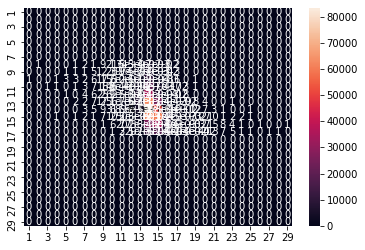

In [14]:
df_cm = pd.DataFrame(cm, range(1,len(cm)+1), range(1,len(cm)+1))
sns.heatmap(df_cm, annot=True);

Since there are 10 classes and 3 classifications in confusion matrix, the matrix graph is 30x30. Visualizing i might not give much relevant information. Thus we prefer relying on accuracy for deciding the best model.  

**2) using TF-IDF:**

In [15]:
op = show_performance(lr, BOW_tv)

Model accuracy on training data (percent): 27.3052
Model accuracy on test data (percent): 27.3382


No significant performance improvement

#### Naive Bayes:

In [20]:
nb = MultinomialNB()

**1) Simple bag of words:**

In [21]:
op = show_performance(nb,BOW)

Model accuracy on training data (percent): 28.5343
Model accuracy on test data (percent): 28.4256


**2) TF-IDF:**

In [22]:
op = show_performance(nb,BOW_tv)

Model accuracy on training data (percent): 28.0514
Model accuracy on test data (percent): 27.9887


---
### Step 5: Evaluation and Hyper-Parameter tuning on Test results:

The goal here is to see if modifying the number of features and affects the output accuracy of classifiers. We will be trying out 20 such feature values starting from 100 to 2000 skipping 100 everytime, and recording the test accuracies.

In [6]:
n_features = np.linspace(100,2000,20)
print(n_features)

[ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100. 1200.
 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000.]


In [23]:
def calc_performance(model,bow):

    model.fit(bow["train"][0],bow["train"][1])
    y_pred = model.predict(bow["test"][0])
    y_pred = conversion(y_pred)
    acc, cm = get_performance_metrics(bow["test"][1], y_pred)
    print("Model accuracy on test data (percent):", round(acc * 100,4))
    
    return acc, cm

def generate_bow(features,tf=False):
    bow = dict()
    if tf:
        tv = TfidfVectorizer(max_features = int(features), analyzer='word', token_pattern=r'\w+', stop_words='english')
        bow["train"] = (tv.fit_transform(X_train), y_train)
        bow["test"]  = (tv.transform(X_test), y_test)
    else:
        cv = CountVectorizer(max_features = int(features), analyzer='word', token_pattern=r'\w+',stop_words='english')
        bow["train"] = (cv.fit_transform(X_train), y_train)
        bow["test"]  = (cv.transform(X_test), y_test)
    return bow
        

In [23]:
accuracies = pd.DataFrame(columns = ['vector-type', 'classifier', 'n_features', 'accuracy'])
for n_f in n_features:
    
    lr = LinearRegression()
    nb = MultinomialNB()
    
    #linear
    # bag of words
    bow = generate_bow(n_f)
    result = calc_performance(lr,bow)
    accuracies = accuracies.append({'vector-type':'bow', 'classifier': 'lr', 'n_features': n_f, 'accuracy': result[0]}, ignore_index=True)
    print({'vector-type':'bow', 'classifier': 'lr', 'n_features': n_f, 'accuracy': result[0]})
    
    # tf-idf
    bow = generate_bow(n_f, True)
    result = calc_performance(lr,bow)
    accuracies = accuracies.append({'vector-type':'tfidf', 'classifier': 'lr', 'n_features': n_f, 'accuracy': result[0]}, ignore_index=True)
    print({'vector-type':'tfidf', 'classifier': 'lr', 'n_features': n_f, 'accuracy': result[0]})
    
    # nbc
    # bag of words
    bow = generate_bow(n_f)
    result = calc_performance(nb,bow)
    accuracies = accuracies.append({'vector-type':'bow', 'classifier': 'nb', 'n_features': n_f, 'accuracy': result[0]}, ignore_index=True)
    print({'vector-type':'bow', 'classifier': 'nb', 'n_features': n_f, 'accuracy': result[0]})
    
    # tf-idf
    bow = generate_bow(n_f, True)
    result = calc_performance(nb,bow)
    accuracies = accuracies.append({'vector-type':'tfidf', 'classifier': 'nb', 'n_features': n_f, 'accuracy': result[0]}, ignore_index=True)
    print({'vector-type':'tfidf', 'classifier': 'nb', 'n_features': n_f, 'accuracy': result[0]})

Model accuracy on test data (percent): 27.8151
{'vector-type': 'bow', 'classifier': 'lr', 'n_features': 1300.0, 'accuracy': 0.27815126751863506}
Model accuracy on test data (percent): 28.0517
{'vector-type': 'tfidf', 'classifier': 'lr', 'n_features': 1300.0, 'accuracy': 0.28051685712139296}
Model accuracy on test data (percent): 29.4013
{'vector-type': 'bow', 'classifier': 'nb', 'n_features': 1300.0, 'accuracy': 0.29401257084665405}
Model accuracy on test data (percent): 28.7433
{'vector-type': 'tfidf', 'classifier': 'nb', 'n_features': 1300.0, 'accuracy': 0.28743332693383195}
Model accuracy on test data (percent): 27.8465
{'vector-type': 'bow', 'classifier': 'lr', 'n_features': 1400.0, 'accuracy': 0.27846512132619927}
Model accuracy on test data (percent): 28.0746
{'vector-type': 'tfidf', 'classifier': 'lr', 'n_features': 1400.0, 'accuracy': 0.2807455697364797}
Model accuracy on test data (percent): 29.4171
{'vector-type': 'bow', 'classifier': 'nb', 'n_features': 1400.0, 'accuracy': 0

Only showing from 1300 to 2000, previous data collected separately and partially since this step is extremely resource intensive and kept crashing the kernel again and again.

In [25]:
accuracies.to_csv('acc.csv',index=False)

In [26]:
accuracies = pd.read_csv('acc.csv')

In [27]:
accuracies.sort_values(by = ['accuracy'],ascending=False)[:5] # top 5 results

,vector-type,classifier,n_features,accuracy
30,bow,nb,2000.0,0.295759
26,bow,nb,1900.0,0.295579
22,bow,nb,1800.0,0.295231
18,bow,nb,1700.0,0.295053
14,bow,nb,1600.0,0.294565


As per the above list, Naive Bayes usign Bag of words seems to have given the best results so far, where number of features = 2000

So we Our final model for this problem is using naive bayes over the bag of words made of the top 2000 high frequency words. 

---
### Step 6: Saving and Loading model mechanizm:
 - using pickle to store the classifier model
 - since its our final model, lets use the entire dataset to train
 - we will use this model on live dataset for prediction.

In [28]:
# using entire dataset for final training
X_train = X
y_train = y

In [29]:
cv = CountVectorizer(max_features = 2000, analyzer='word', token_pattern=r'\w+',stop_words='english') 
cv_model = cv.fit(X)

In [30]:
pickle.dump(cv,open('cv_vectorizer','wb'))

In [32]:
bow = generate_bow(2000)
nb = MultinomialNB().fit(bow['train'][0],bow['train'][1])
pickle.dump(nb,open('nb_classifier','wb'))

In [33]:
model = pickle.load(open('nb_classifier', 'rb'))

### References:
The resources and previous experiments that were referred to implement this project
 - https://stackabuse.com/text-classification-with-python-and-scikit-learn/
 - https://towardsdatascience.com/training-a-naive-bayes-model-to-identify-the-author-of-an-email-or-document-17dc85fa630a
 - https://www.kaggle.com/loryn808/baseline-bag-of-words-linear-regression